In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler

# Problem 1: RNNs as a generative model



In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
def make_block(image):
  out = []
  for i in range(4):
    for j in range(4):
        patch = image[i * 7:(i + 1) * 7, j * 7:(j + 1) * 7]
        out.append(patch.reshape(-1))
  return np.array(out)

In [ ]:
x_train = np.array([make_block(image) for image in x_train])
x_test = np.array([make_block(image) for image in x_test])

In [ ]:
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=64, input_shape=(None, 49), return_sequences=True, activation='tanh'))
lstm_model.add(tf.keras.layers.LSTM(units=64, return_sequences=True, activation='tanh'))
lstm_model.add(tf.keras.layers.Dense(units=49, activation='relu'))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
lstm_model.fit(x_train[:,0:15,:], x_train[:,1:16,:], callbacks = callback, epochs=100, batch_size=100,validation_data=[x_test[:,0:15,:],x_test[:,1:16,:]])

Epoch 1/100
600/600 [==============================] - 6s 6ms/step - loss: 0.0625 - val_loss: 0.0471
Epoch 2/100
600/600 [==============================] - 3s 5ms/step - loss: 0.0440 - val_loss: 0.0411
Epoch 3/100
600/600 [==============================] - 3s 5ms/step - loss: 0.0401 - val_loss: 0.0385
Epoch 4/100
600/600 [==============================] - 3s 5ms/step - loss: 0.0379 - val_loss: 0.0369
Epoch 5/100
600/600 [==============================] - 3s 5ms/step - loss: 0.0365 - val_loss: 0.0356
Epoch 6/100
600/600 [==============================] - 3s 5ms/step - loss: 0.0354 - val_loss: 0.0348
Epoch 7/100
600/600 [==============================] - 3s 5ms/step - loss: 0.0347 - val_loss: 0.0342
Epoch 8/100
600/600 [==============================] - 3s 5ms/step - loss: 0.0340 - val_loss: 0.0338
Epoch 9/100
600/600 [==============================] - 3s 5ms/step - loss: 0.0335 - val_loss: 0.0333
Epoch 10/100
600/600 [==============================] - 3s 5ms/step - loss: 0.0331 - val_lo

In [ ]:
def lstm_predict(data):
  train = data[0:8]
  out = lstm_model.predict(train.reshape(1,8,49))
  for i in range(7):
    l = lstm_model.predict(out)
    out = np.hstack((out, l[:,-1,:].reshape(1,1,49)))
  images = np.concatenate((train,out[0,7:])).reshape(16,7,7)
  reconstructed_image = np.zeros((28, 28))
  for row in range(4):
    for col in range(4):
      reconstructed_image[row*7:(row+1)*7, col*7:(col+1)*7] = images[row*4+col]
  return reconstructed_image


In [ ]:
test_image = lstm_predict(x_test[1])

1/1 [==============================] - 0s 24ms/step


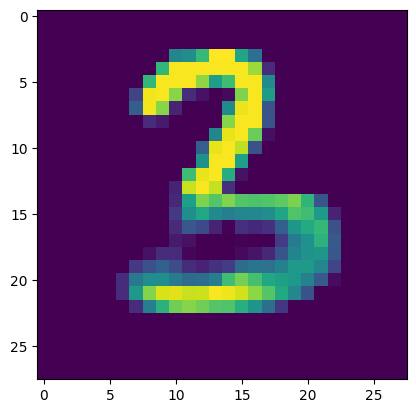

In [ ]:
plt.imshow(test_image)

In [ ]:
(_, _), (x_test_orig, y_test_orig) = tf.keras.datasets.mnist.load_data()

In [ ]:
images = []

for label in range(10):
    selected_indices = np.where(y_test_orig == label)[0][:10]
    images.append(x_test_orig[selected_indices])
images = np.concatenate(images)
images = images / 255.0
images_block = np.array([make_block(image) for image in images])

In [ ]:
predictions = []
for i in range(100):
  predictions.append(lstm_predict(images_block[i]))

1/1 [==============================] - 0s 19ms/step


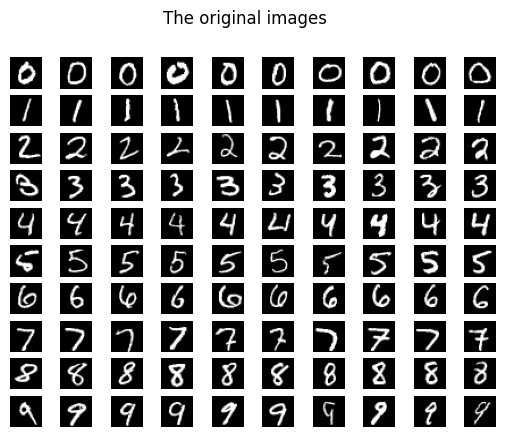

In [ ]:
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10, 10*i+j+1)
    plt.imshow(images[10*i+j], cmap='gray')
    plt.axis('off')
plt.suptitle('The original images')
plt.show()

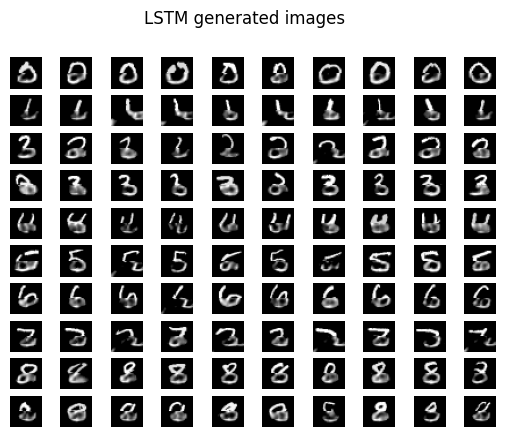

In [ ]:
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10, 10*i+j+1)
    plt.imshow(predictions[10*i+j], cmap='gray')
    plt.axis('off')

plt.suptitle('LSTM generated images')
plt.show()

# Problem 2: Variational Autoencoders on Poor Sevens

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hw5_te7.pkl to hw5_te7.pkl
Saving hw5_tr7.pkl to hw5_tr7.pkl


In [ ]:
with open('hw5_tr7.pkl', 'rb') as f:
    train = pickle.load(f)
with open('hw5_te7.pkl', 'rb') as f:
    test = pickle.load(f)


train = train.reshape([6265,28,28,1])
test = test.reshape([1028,28,28,1])

I used the architecture from https://www.tensorflow.org/tutorials/generative/cvae

In [ ]:
latent_dim = 3  # Set the number of latent dimensions

In [ ]:
# Define the encoder
encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(latent_dim + latent_dim)(x)

In [ ]:
# Define the reparameterization
mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
def sampling(args):
    mean, log_var = args
    batch = tf.shape(mean)[0]
    dim = tf.shape(mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return mean + tf.exp(0.5 * log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([mean, log_var])

In [ ]:
# Define the decoder
decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(7 * 7 * 32, activation="relu")(decoder_inputs)
x = tf.keras.layers.Reshape((7, 7, 32))(x)
x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, padding="same")(x)

In [ ]:
# Define the vae model
encoder = tf.keras.models.Model(encoder_inputs, [mean, log_var, z], name='encoder')
decoder = tf.keras.models.Model(decoder_inputs, decoder_outputs, name='decoder')
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = tf.keras.models.Model(encoder_inputs, vae_outputs, name='vae')

In [ ]:
# Define loss function
reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(encoder_inputs, vae_outputs),
                    axis=(1, 2),
                )
            )
kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
total_loss = reconstruction_loss + kl_loss

In [ ]:
vae.add_loss(total_loss)
vae.compile(optimizer='adam')
vae.fit(train,epochs=50, batch_size=128)

Epoch 1/50
49/49 [==============================] - 5s 56ms/step - loss: 298.8104
Epoch 2/50
49/49 [==============================] - 3s 55ms/step - loss: 219.3432
Epoch 3/50
49/49 [==============================] - 3s 61ms/step - loss: 188.1163
Epoch 4/50
49/49 [==============================] - 3s 58ms/step - loss: 166.2105
Epoch 5/50
49/49 [==============================] - 3s 56ms/step - loss: 157.2429
Epoch 6/50
49/49 [==============================] - 3s 56ms/step - loss: 153.8700
Epoch 7/50
49/49 [==============================] - 3s 57ms/step - loss: 150.5512
Epoch 8/50
49/49 [==============================] - 3s 68ms/step - loss: 149.2086
Epoch 9/50
49/49 [==============================] - 3s 56ms/step - loss: 150.4904
Epoch 10/50
49/49 [==============================] - 3s 57ms/step - loss: 145.6998
Epoch 11/50
49/49 [==============================] - 3s 55ms/step - loss: 145.2469
Epoch 12/50
49/49 [==============================] - 3s 57ms/step - loss: 143.3060
Epoch 13/50
4

In [ ]:
# Generate figure
num_figure = 16
random_sample_1 = np.random.normal(loc = 0, scale = 1)
random_sample_2 = np.random.normal(loc = 0, scale = 1)
sample = np.linspace(-5.0, 5.0, num_figure)

In [ ]:
figure1 = np.zeros((num_figure,28,28))
figure2 = np.zeros((num_figure,28,28))
figure3 = np.zeros((num_figure,28,28))

In [ ]:
for k in range(num_figure):
  z1 = np.array([[sample[k],random_sample_1,random_sample_2]])
  z2 = np.array([[random_sample_1,sample[k],random_sample_2]])
  z3 = np.array([[random_sample_1,random_sample_2,sample[k]]])

  predict1 = decoder.predict(z1)
  predict2 = decoder.predict(z2)
  predict3 = decoder.predict(z3)

  figure1[k] = predict1[0].reshape(28, 28)
  figure2[k] = predict2[0].reshape(28, 28)
  figure3[k] = predict3[0].reshape(28, 28)

1/1 [==============================] - 0s 22ms/step


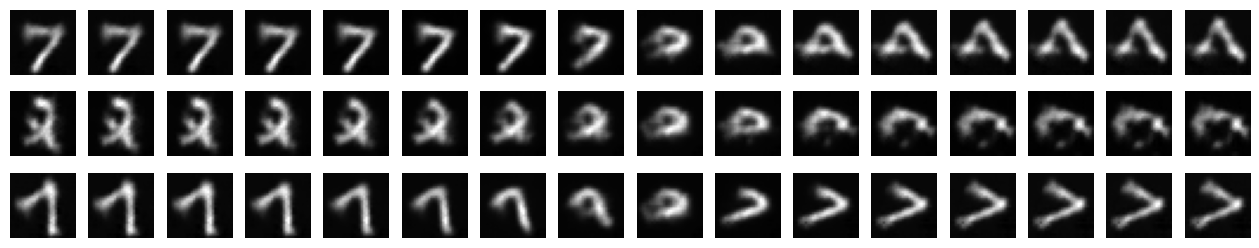

In [ ]:
fig, ax = plt.subplots(3,16,figsize=(16,3))
for i in range(16):
    ax[0,i].imshow(figure1[i], cmap='gray')
    ax[0,i].axis('off')
    ax[1,i].imshow(figure2[i], cmap='gray')
    ax[1,i].axis('off')
    ax[2,i].imshow(figure3[i], cmap='gray')
    ax[2,i].axis('off')

From the pictures above, we can see a sigficant changing effect in dimension 1,2

# Problem 3: Conditional GAN

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])
all_digits = all_digits / 255.0
all_digits = (all_digits - .5) *2.
all_digits = all_digits.reshape(all_digits.shape[0],784)
all_labels = tf.one_hot(all_labels,10).numpy()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
latent_dim = 100

In [ ]:
random_input = tf.keras.Input(shape=(latent_dim,))
img_input = tf.keras.Input(shape=(784,))
onehot_input = tf.keras.Input(shape=(10,))

In [ ]:
generator_inputs = tf.keras.layers.Concatenate()([random_input,onehot_input])
x = tf.keras.layers.Dense(200,activation='relu')(generator_inputs)
x = tf.keras.layers.BatchNormalization(momentum=0.6)(x)
x = tf.keras.layers.Dense(400,activation='relu')(x)
x = tf.keras.layers.BatchNormalization(momentum=0.6)(x)
generator_outputs = tf.keras.layers.Dense(784, activation='tanh')(x)
generator = tf.keras.Model([random_input, onehot_input], generator_outputs)

In [ ]:
discriminator_inputs = tf.keras.layers.Concatenate()([img_input,onehot_input])
x = tf.keras.layers.Dense(400,)(discriminator_inputs)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(200)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Dropout(0.3)(x)
discriminator_outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
discriminator = tf.keras.Model([img_input,onehot_input], discriminator_outputs)

In [ ]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.0001, 0.5), metrics = ['accuracy'])

In [ ]:
discriminator.trainable = False
cgan_inputs = [random_input,onehot_input]
cgan_outputs = discriminator([generator(cgan_inputs),onehot_input])
cgan = tf.keras.Model(cgan_inputs, cgan_outputs)
cgan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001,0.5))

In [ ]:
epochs = 100
batch_size = 256

real_accuracy = []
fake_accuracy = []
y_real = np.ones((batch_size, 1))
y_fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
  # Train discriminator 5 times before training the generator
  for i in range(0,len(all_digits),batch_size):
    # Train discriminator
    discriminator.trainable = True
    X_batch = all_digits[i:i+batch_size]
    labels = all_labels[i:i+batch_size]

    # train with real values

    loss_real, acc_real = discriminator.train_on_batch([X_batch, labels], y_real[:labels.shape[0]])

    # train with fake values
    noise = np.random.normal(0,1,size = (batch_size, latent_dim))
    labels_fake = tf.one_hot(np.random.randint(0,10,batch_size), 10).numpy()
    X_fake = generator.predict([noise, labels_fake])

    loss_fake, acc_fake = discriminator.train_on_batch([X_fake, labels_fake], y_fake)

    # Train cGAN
    discriminator.trainable = False
    loss_gan = cgan.train_on_batch([noise, labels_fake], y_real)

    print(f"Epoch: {epoch} |{acc_real} |{acc_fake} ")
    real_accuracy.append(acc_real)
    fake_accuracy.append(acc_fake)


Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 2ms/step
Epoch: 90 |0.52734375 |0.609375 
8/8 [==============================] - 0s 2ms/step
Epoch: 90 |0.515625 |0.64453125 
8/8 [==============================] - 0s 2ms/step
Epoch: 90 |0.55078125 |0.6484375 
8/8 [==============================] - 0s 2ms/step
Epoch: 90 |0.4765625 |0.578125 
8/8 [==============================] - 0s 2ms/step
Epoch: 90 |0.49609375 |0.60546875 
8/8 [==============================] - 0s 2ms/step
Epoch: 90 |0.5546875 |0.6484375 
8/8 [==============================] - 0s 2ms/step
Epoch: 90 |0.53125 |0.62890625 
8/8 [==============================] - 0s 2ms/step
Epoch: 90 |0.55078125 |0.59765625 
8/8 [==============================] - 0s 2ms/step
Epoch: 90 |0.53125 |0.61328125 
8/8 [==============================] - 0s 2ms/step
Epoch: 90 |0.609375 |0.64453125 
8/8 [==============================] - 0s 2ms/step
Epoch: 90 |0.56640625 |0.6171875 
8/8 [=================

In [ ]:
X = np.linspace(0,100,len(real_accuracy))

Text(0.5, 1.0, 'Discriminator Accuracy of Real and Fake images')

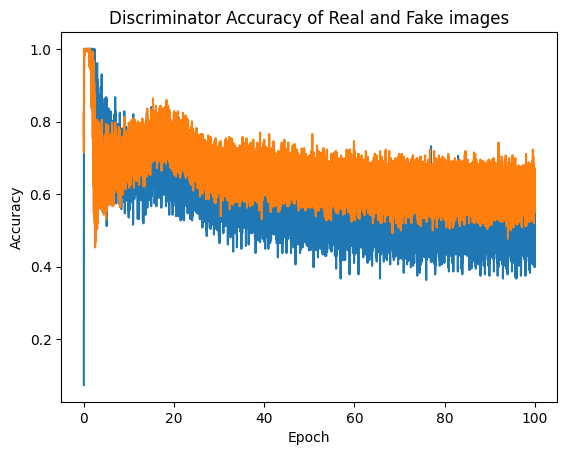

In [ ]:
plt.plot(X, real_accuracy);
plt.plot(X, fake_accuracy);
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Discriminator Accuracy of Real and Fake images")

4/4 [==============================] - 0s 2ms/step


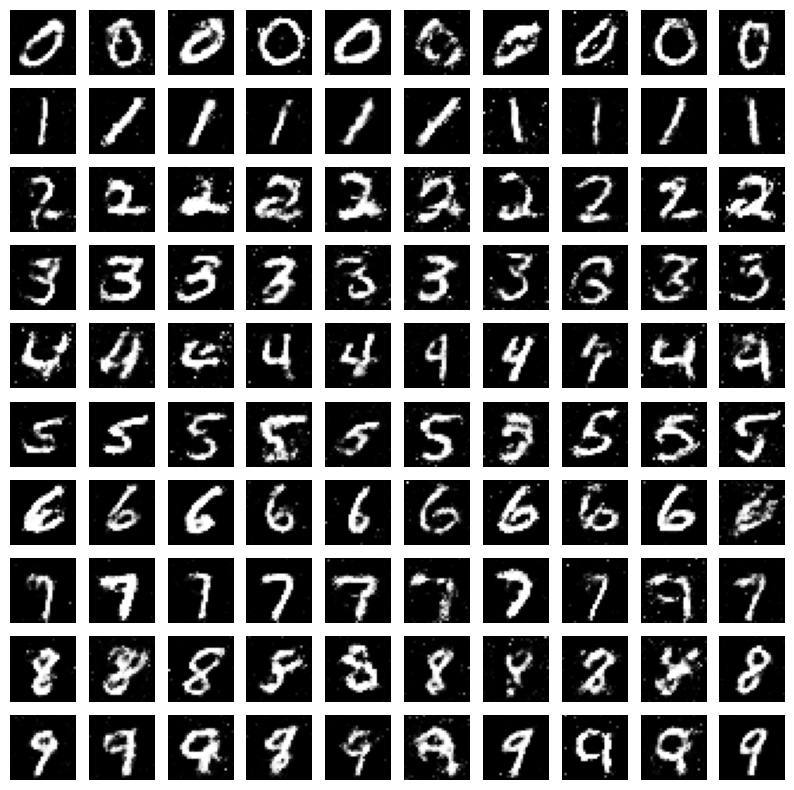

In [ ]:
labels = np.array([tf.one_hot(i, 10).numpy() for i in range(10)for _ in range(10) ])
noise = np.random.normal(0,1,(labels.shape[0], 100))
image = generator.predict([noise,labels])
image = image + 1
fig, ax = plt.subplots(10,10, figsize = (10,10))

i = 0
for j in range(10):
    for k in range(10):
        ax[j,k].imshow(image[i,:].reshape((28,28)),cmap = 'gray')
        ax[j,k].axis('off')
        i+=1

# Problem 4: Missing Value Imputation Using Conditional GAN

Reference: https://hub.packtpub.com/how-to-build-a-neural-network-to-fill-the-missing-part-of-a-handwritten-digit-using-gans-tutorial/

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])
all_digits = all_digits / 255.0
train = (all_digits - .5) *2.
train_center = train[:,10:19,10:19]

In [21]:
train = train.reshape(-1,784)
train_center = train_center.reshape(-1,train_center.shape[1]*train_center.shape[2])

In [22]:
latent_dim = 100
lambda_mse = 10

In [23]:
random_input = tf.keras.Input(shape=(latent_dim,))
img_input = tf.keras.Input(shape=(784,))
center_input = tf.keras.Input(shape=(train_center.shape[1],))

In [24]:
discriminator_inputs = tf.keras.layers.Concatenate()([img_input])
x = tf.keras.layers.Dense(400,)(discriminator_inputs)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(200)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Dropout(0.2)(x)
discriminator_outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
discriminator = tf.keras.Model(img_input, discriminator_outputs)

In [25]:
generator_inputs = tf.keras.layers.Concatenate()([random_input,center_input])
x = tf.keras.layers.Dense(200,activation='relu')(generator_inputs)
x = tf.keras.layers.BatchNormalization(momentum=0.6)(x)
x = tf.keras.layers.Dense(400,activation='relu')(x)
x = tf.keras.layers.BatchNormalization(momentum=0.6)(x)
generator_outputs = tf.keras.layers.Dense(784, activation='tanh')(x)
generator = tf.keras.Model([random_input, center_input], generator_outputs)

In [26]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.0001, 0.5), metrics = ['accuracy'])

In [27]:
discriminator.trainable = False
cgan_inputs = [random_input,center_input]
cgan_outputs = discriminator(generator(cgan_inputs))
cgan = tf.keras.Model(cgan_inputs, cgan_outputs)

generator_outputs_reshaped = tf.reshape(generator_outputs, (-1, 28, 28))  # Adjust dimensions based on your actual output shape
center_pixels_generated = generator_outputs_reshaped[:, 10:19, 10:19]
center_pixels_generated = tf.reshape(center_pixels_generated, (-1,81))
mse_loss = tf.keras.losses.mean_squared_error(center_input, center_pixels_generated)

bce_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(cgan_outputs), cgan_outputs)

cgan.add_loss(bce_loss+lambda_mse*mse_loss)
cgan.compile(optimizer=tf.keras.optimizers.Adam(0.0001,0.5))

In [28]:
epochs = 100
batch_size = 256

real_accuracy = []
fake_accuracy = []
y_real = np.ones((batch_size, 1))
y_fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
  # Train discriminator 5 times before training the generator
  for i in range(0,len(all_digits),batch_size):
    # Train discriminator
    discriminator.trainable = True
    X_batch = train[i:i+batch_size]
    center_batch = train_center[i:i+batch_size]

    # train with real values

    loss_real, acc_real = discriminator.train_on_batch([X_batch], y_real[:center_batch.shape[0]])

    # train with fake values
    noise = np.random.normal(0,1,size = (center_batch.shape[0], latent_dim))
    noise_center = np.random.normal(0,1,size = (batch_size, train_center.shape[1]))
    X_fake = generator.predict([noise, center_batch])

    loss_fake, acc_fake = discriminator.train_on_batch([X_fake], y_fake[:X_fake.shape[0]])

    # Train cGAN after 20 epochs
    if epoch > 20:
        discriminator.trainable = False
        loss_gan = cgan.train_on_batch([noise, center_batch], y_real[:center_batch.shape[0]])

    print(f"Epoch: {epoch} |{acc_real} |{acc_fake} ")
    real_accuracy.append(acc_real)
    fake_accuracy.append(acc_fake)


Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 3ms/step
Epoch: 90 |0.5859375 |0.64453125 
8/8 [==============================] - 0s 3ms/step
Epoch: 90 |0.578125 |0.72265625 
8/8 [==============================] - 0s 4ms/step
Epoch: 90 |0.62109375 |0.7578125 
8/8 [==============================] - 0s 3ms/step
Epoch: 90 |0.609375 |0.65234375 
8/8 [==============================] - 0s 3ms/step
Epoch: 90 |0.5625 |0.6875 
8/8 [==============================] - 0s 3ms/step
Epoch: 90 |0.5859375 |0.7109375 
8/8 [==============================] - 0s 3ms/step
Epoch: 90 |0.578125 |0.72265625 
8/8 [==============================] - 0s 3ms/step
Epoch: 90 |0.5859375 |0.75390625 
8/8 [==============================] - 0s 3ms/step
Epoch: 90 |0.61328125 |0.71875 
8/8 [==============================] - 0s 3ms/step
Epoch: 90 |0.58203125 |0.671875 
8/8 [==============================] - 0s 3ms/step
Epoch: 90 |0.59375 |0.6875 
8/8 [=============================

4/4 [==============================] - 0s 4ms/step


Text(0.5, 0.98, 'Cgan generated images with regularizer')

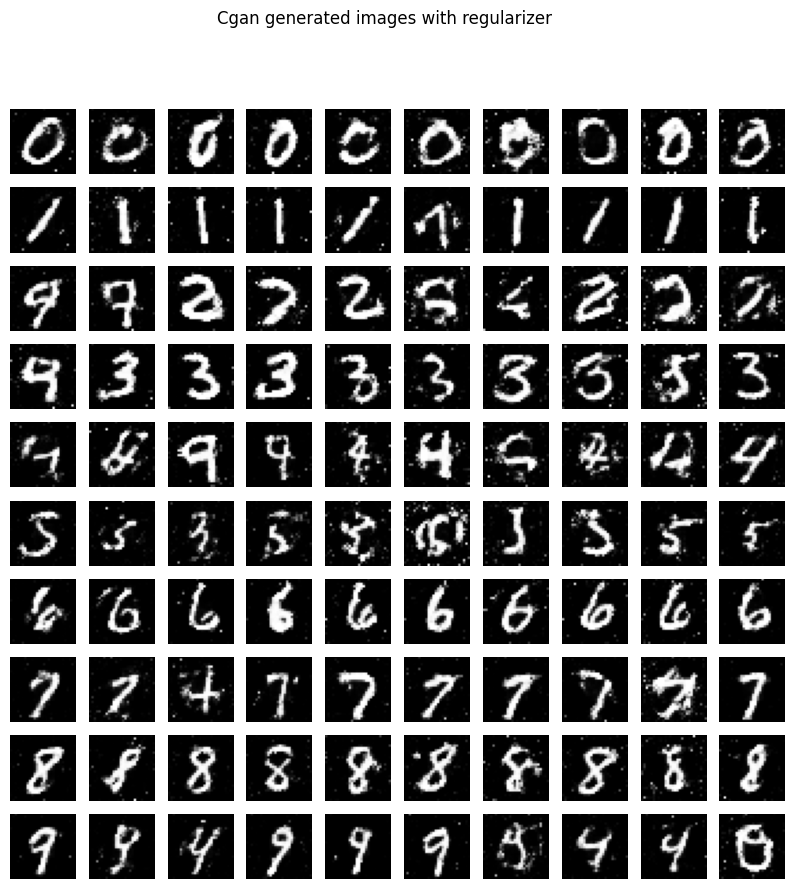

In [32]:
images = []

for label in range(10):
    selected_indices = np.where(all_labels == label)[0][:10]
    images.append(train[selected_indices])
images = np.concatenate(images)
images = images.reshape(-1,28,28)

mean_patch = images[:,10:19,10:19]
mean_patch = mean_patch.reshape(-1, 81)

noise = np.random.normal(0,1,(mean_patch.shape[0], 100))
image = generator.predict([noise,mean_patch])
image = image + 1

fig, ax = plt.subplots(10,10, figsize = (10,10))
i = 0
for j in range(10):
    for k in range(10):
        ax[j,k].imshow(image[i,:].reshape((28,28)),cmap = 'gray')
        ax[j,k].axis('off')
        i+=1
plt.suptitle('Cgan generated images with regularizer')

In [ ]:
!jupyter nbconvert --to html /content/your_notebook.ipynb